In [1]:
from censai import RIMSharedUnet, PhysicalModel, RIMUnet, PowerSpectrum
from censai.models import SharedUnetModel, UnetModel
from censai.definitions import log_10
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from censai.data.lenses_tng import decode_train, decode_physical_model_info
import os, glob, json
from argparse import Namespace
import h5py
from tqdm import tqdm

In [2]:
datapath = "/home/aadam/scratch/Censai/data/lenses512_hk128_TNG100_10k_verydiffuse"


files = glob.glob(os.path.join(datapath, "*.tfrecords"))
files = tf.data.Dataset.from_tensor_slices(files)
dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type="GZIP"), block_length=1, num_parallel_calls=tf.data.AUTOTUNE)
for physical_params in dataset.map(decode_physical_model_info):
    break
print(physical_params)
dataset = dataset.map(decode_train)

{'image fov': <tf.Tensor: shape=(), dtype=float32, numpy=17.425909>, 'kappa fov': <tf.Tensor: shape=(), dtype=float32, numpy=17.425909>, 'source fov': <tf.Tensor: shape=(), dtype=float32, numpy=10.0>, 'src pixels': <tf.Tensor: shape=(), dtype=int64, numpy=128>, 'kappa pixels': <tf.Tensor: shape=(), dtype=int64, numpy=128>, 'pixels': <tf.Tensor: shape=(), dtype=int64, numpy=512>, 'noise rms': <tf.Tensor: shape=(), dtype=float32, numpy=0.006>, 'psf sigma': <tf.Tensor: shape=(), dtype=float32, numpy=0.08>}


In [3]:
model_id = "RIMSU512_hk128_TNG2nsO_008_F16_IK7_NLrelu_82_B10_lr0.0005_dr0.5_ds10000_211005114812"
forward_method = "fft"
raytracer = None
checkpoints_dir = os.path.join(os.getenv("CENSAI_PATH"), "models", model_id)


with open(os.path.join(checkpoints_dir, "script_params.json"), "r") as f:
    args = json.load(f)
args = Namespace(**args)

phys = PhysicalModel(
    pixels=physical_params["pixels"].numpy(),
    kappa_pixels=physical_params["kappa pixels"].numpy(),
    src_pixels=physical_params["src pixels"].numpy(),
    image_fov=physical_params["image fov"].numpy(),
    kappa_fov=physical_params["kappa fov"].numpy(),
    src_fov=physical_params["source fov"].numpy(),
    method="fft",
    noise_rms=physical_params["noise rms"].numpy(),
    raytracer=raytracer,
    psf_sigma=physical_params["psf sigma"].numpy()
)

unet = SharedUnetModel(
    filters=args.filters,
    filter_scaling=args.filter_scaling,
    kernel_size=args.kernel_size,
    layers=args.layers,
    block_conv_layers=args.block_conv_layers,
    strides=args.strides,
    bottleneck_kernel_size=args.bottleneck_kernel_size,
    bottleneck_filters=args.bottleneck_filters,
    resampling_kernel_size=args.resampling_kernel_size,
    input_kernel_size=args.input_kernel_size,
    gru_kernel_size=args.gru_kernel_size,
    upsampling_interpolation=args.upsampling_interpolation,
    kernel_l2_amp=args.kernel_l2_amp,
    bias_l2_amp=args.bias_l2_amp,
    kernel_l1_amp=args.kernel_l1_amp,
    bias_l1_amp=args.bias_l1_amp,
    activation=args.activation,
    alpha=args.alpha,
    initializer=args.initializer,
    batch_norm=args.batch_norm,
    dropout_rate=args.dropout_rate
)
rim = RIMSharedUnet(
    physical_model=phys,
    unet=unet,
    steps=args.steps,
    adam=args.adam,
    kappalog=args.kappalog,
    source_link=args.source_link,
    kappa_normalize=args.kappa_normalize,
    kappa_init=args.kappa_init,
    source_init=args.source_init
)
ckpt = tf.train.Checkpoint(net=rim.unet)
checkpoint_manager = tf.train.CheckpointManager(ckpt, checkpoints_dir, max_to_keep=args.max_to_keep)
checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint).expect_partial()

In [4]:
ps_lens = PowerSpectrum(bins=50, pixels=512)
ps_kappa_source = PowerSpectrum(bins=30, pixels=128)

In [5]:
r_lens = []
r_kappa = []
r_source = []
i = 0
for batch, (lens, source, kappa) in tqdm(enumerate(dataset)):
    source_pred, kappa_pred, chi = rim.predict(lens[None, ...])
    lens_pred = phys.forward(source_pred[-1], kappa_pred[-1])
    
    r_lens.append(ps_lens.cross_correlation_coefficient(lens[None, ..., 0], lens_pred[..., 0]))
    r_kappa.append(ps_kappa_source.cross_correlation_coefficient(log_10(kappa)[None, ..., 0], log_10(kappa_pred[-1])[..., 0]))
    r_source.append(ps_kappa_source.cross_correlation_coefficient(source[None, ..., 0], source_pred[-1][..., 0]))
    if i == 1000:
        break
    i += 1

1000it [16:16,  1.02it/s]


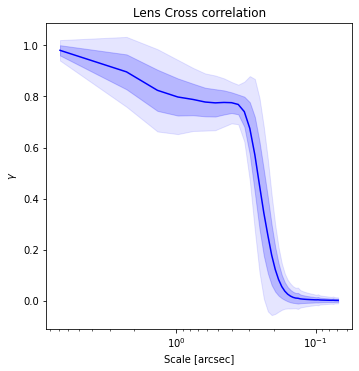

In [6]:
r = np.concatenate(r_lens)
color = "b"
ps = ps_lens
fov = phys.image_fov


r_mean = r.mean(axis=0)
r_std = r.std(axis=0)
_, f = np.histogram(np.arange(ps.pixels//2)/fov, bins=ps.bins)
f = (f[:-1] + f[1:])/2
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0.1, 0.1, 0.85, 0.85])
ax.plot(1/f, r_mean, "-", color=color)
ax.fill_between(1/f, r_mean - r_std, r_mean + r_std, color=color, alpha=0.2)
ax.fill_between(1/f, r_mean - 2 * r_std, r_mean + 2 * r_std, color=color, alpha=0.1)
ax.set_xlabel(r"Scale [arcsec]")
plt.gca().invert_xaxis()
plt.xscale("log")
ax.set_ylabel(rf"$\gamma$")
plt.title("Lens Cross correlation")
plt.plot();

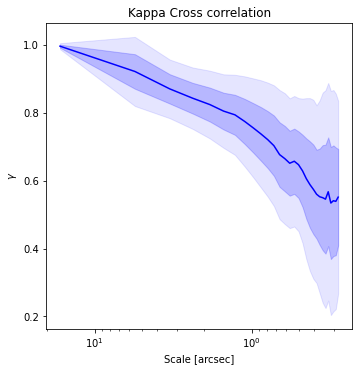

In [7]:
r = np.concatenate(r_kappa)
color = "b"
ps = ps_kappa_source
fov = phys.kappa_fov


r_mean = r.mean(axis=0)
r_std = r.std(axis=0)
_, f = np.histogram(np.arange(ps.pixels//2)/fov, bins=ps.bins)
f = (f[:-1] + f[1:])/2
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0.1, 0.1, 0.85, 0.85])
ax.plot(1/f, r_mean, "-", color=color)
ax.fill_between(1/f, r_mean - r_std, r_mean + r_std, color=color, alpha=0.2)
ax.fill_between(1/f, r_mean - 2 * r_std, r_mean + 2 * r_std, color=color, alpha=0.1)
ax.set_xlabel(r"Scale [arcsec]")
plt.gca().invert_xaxis()
plt.xscale("log")
ax.set_ylabel(rf"$\gamma$")
plt.title("Kappa Cross correlation")
plt.plot();

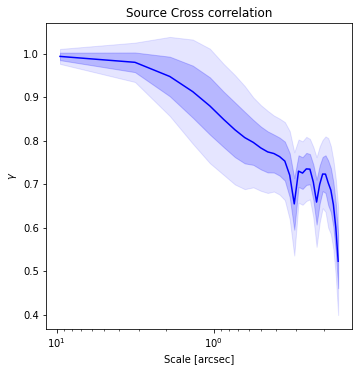

In [8]:
r = np.concatenate(r_source)
color = "b"
ps = ps_kappa_source
fov = phys.src_fov


r_mean = r.mean(axis=0)
r_std = r.std(axis=0)
_, f = np.histogram(np.arange(ps.pixels//2)/fov, bins=ps.bins)
f = (f[:-1] + f[1:])/2
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0.1, 0.1, 0.85, 0.85])
ax.plot(1/f, r_mean, "-", color=color)
ax.fill_between(1/f, r_mean - r_std, r_mean + r_std, color=color, alpha=0.2)
ax.fill_between(1/f, r_mean - 2 * r_std, r_mean + 2 * r_std, color=color, alpha=0.1)
ax.set_xlabel(r"Scale [arcsec]")
plt.gca().invert_xaxis()
plt.xscale("log")
ax.set_ylabel(rf"$\gamma$")
plt.title("Source Cross correlation")
plt.plot();